In [80]:
#Biodegradable Waste Segregation
#Transfer Learning on ResNet50
#importing dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import warnings
warnings.filterwarnings('ignore', message='Palette images with Transparency expressed in bytes should be converted to RGBA images')


In [81]:
#unzipping data
import zipfile
with zipfile.ZipFile('dataset/Dataset_ThirdStage.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset/')

In [82]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

In [83]:
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [86]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the new directory structure
base_dir = 'dataset/waste_classification'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_biodegradable_dir = os.path.join(train_dir, 'biodegradable')
train_non_biodegradable_dir = os.path.join(train_dir, 'non_biodegradable')

validation_biodegradable_dir = os.path.join(validation_dir, 'biodegradable')
validation_non_biodegradable_dir = os.path.join(validation_dir, 'non_biodegradable')

test_biodegradable_dir = os.path.join(test_dir, 'biodegradable')
test_non_biodegradable_dir = os.path.join(test_dir, 'non_biodegradable')

# Create the directories
os.makedirs(train_biodegradable_dir, exist_ok=True)
os.makedirs(train_non_biodegradable_dir, exist_ok=True)
os.makedirs(validation_biodegradable_dir, exist_ok=True)
os.makedirs(validation_non_biodegradable_dir, exist_ok=True)
os.makedirs(test_biodegradable_dir, exist_ok=True)
os.makedirs(test_non_biodegradable_dir, exist_ok=True)


In [ ]:
biodegradable_classes = [
    'A_Foods', 'B_Animal Dead Body', 'C_Cardboard', 'D_Newspaper', 
    'E_Paper Cups', 'F_Papers'
]

source_dir = 'dataset/Dataset'
all_classes = os.listdir(source_dir)
biodegradable_files = []
non_biodegradable_files = []

for class_name in all_classes:
    class_dir = os.path.join(source_dir, class_name)
    if os.path.isdir(class_dir):
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        if class_name in biodegradable_classes:
            biodegradable_files.extend(files)
        else:
            non_biodegradable_files.extend(files)

print(f"Found {len(biodegradable_files)} biodegradable files")
print(f"Found {len(non_biodegradable_files)} non-biodegradable files")

# Split the data
def split_and_copy(files, train_dest, val_dest, test_dest):
    if len(files) == 0:
        print(f"Warning: No files found for copying to {train_dest}")
        return
    
    # Split into train and test
    train_val_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    # Split train into train and validation
    train_files, val_files = train_test_split(train_val_files, test_size=0.2, random_state=42)

    # Copy files
    for f in train_files:
        shutil.copy(f, train_dest)
    for f in val_files:
        shutil.copy(f, val_dest)
    for f in test_files:
        shutil.copy(f, test_dest)

# Split and copy biodegradable files
split_and_copy(biodegradable_files, train_biodegradable_dir, validation_biodegradable_dir, test_biodegradable_dir)

# Split and copy non-biodegradable files
split_and_copy(non_biodegradable_files, train_non_biodegradable_dir, validation_non_biodegradable_dir, test_non_biodegradable_dir)

Found 8849 biodegradable files
Found 26415 non-biodegradable files


In [88]:
#data augmentation to the training data

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#rescale the validation data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 22568 images belonging to 2 classes.
Found 5643 images belonging to 2 classes.
Found 5643 images belonging to 2 classes.


In [89]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [93]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,659,589 (383.99 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 51,381,252 (196.00 MB)

In [90]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
batch_size = 32
epochs = 5

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

C:\Users\arsha\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 569s 800ms/step - accuracy: 0.8900 - loss: 0.4803 - val_accuracy: 0.9421 - val_loss: 0.1354
Epoch 2/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 569s 800ms/step - accuracy: 0.8900 - loss: 0.4803 - val_accuracy: 0.9421 - val_loss: 0.1354
Epoch 2/5
  1/705 ━━━━━━━━━━━━━━━━━━━━ 5:56 506ms/step - accuracy: 0.9062 - loss: 0.1533

C:\Users\arsha\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


705/705 ━━━━━━━━━━━━━━━━━━━━ 80s 112ms/step - accuracy: 0.9062 - loss: 0.1533 - val_accuracy: 0.9425 - val_loss: 0.1352
Epoch 3/5
Epoch 3/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 519s 736ms/step - accuracy: 0.9247 - loss: 0.1880 - val_accuracy: 0.9528 - val_loss: 0.1269
Epoch 4/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 519s 736ms/step - accuracy: 0.9247 - loss: 0.1880 - val_accuracy: 0.9528 - val_loss: 0.1269
Epoch 4/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.9375 - loss: 0.1270 - val_accuracy: 0.9524 - val_loss: 0.1291
Epoch 5/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.9375 - loss: 0.1270 - val_accuracy: 0.9524 - val_loss: 0.1291
Epoch 5/5
705/705 ━━━━━━━━━━━━━━━━━━━━ 543s 770ms/step - accuracy: 0.9318 - loss: 0.1693 - val_accuracy: 0.9533 - val_loss: 0.1287
705/705 ━━━━━━━━━━━━━━━━━━━━ 543s 770ms/step - accuracy: 0.9318 - loss: 0.1693 - val_accuracy: 0.9533 - val_loss: 0.1287


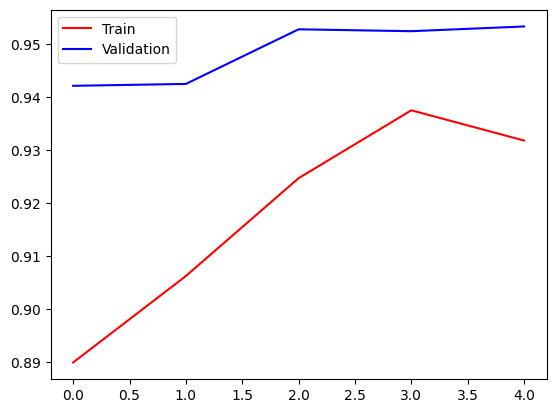

In [92]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

In [94]:
# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for consistent evaluation
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for detailed analysis
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

# Print classification report
print("\nClassification Report:")
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(f"True Negatives (Class 0): {cm[0,0]}")
print(f"False Positives (Class 0): {cm[0,1]}")
print(f"False Negatives (Class 1): {cm[1,0]}")
print(f"True Positives (Class 1): {cm[1,1]}")

# Calculate per-class accuracy
class_0_accuracy = cm[0,0] / (cm[0,0] + cm[0,1])
class_1_accuracy = cm[1,1] / (cm[1,1] + cm[1,0])
print(f"\nPer-class Accuracy:")
print(f"{class_names[0]} accuracy: {class_0_accuracy:.4f}")
print(f"{class_names[1]} accuracy: {class_1_accuracy:.4f}")

# Check for any data leakage indicators
total_samples = len(test_generator.filenames)
print(f"\nTest set size verification: {total_samples} images")
print(f"Class distribution in test set:")
print(f"Class 0: {np.sum(y_true == 0)} images ({np.sum(y_true == 0)/total_samples*100:.1f}%)")
print(f"Class 1: {np.sum(y_true == 1)} images ({np.sum(y_true == 1)/total_samples*100:.1f}%)")

Found 7053 images belonging to 2 classes.
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.9534 - loss: 0.1242
221/221 ━━━━━━━━━━━━━━━━━━━━ 95s 429ms/step - accuracy: 0.9534 - loss: 0.1242

Test Accuracy: 0.9534
Test Loss: 0.1242

Test Accuracy: 0.9534
Test Loss: 0.1242
221/221 ━━━━━━━━━━━━━━━━━━━━ 100s 447ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 100s 447ms/step

Classification Report:
                   precision    recall  f1-score   support

    biodegradable       0.95      0.86      0.90      1770
non_biodegradable       0.95      0.99      0.97      5283

         accuracy                           0.95      7053
        macro avg       0.95      0.92      0.94      7053
     weighted avg       0.95      0.95      0.95      7053


Confusion Matrix:
True Negatives (Class 0): 1520
False Positives (Class 0): 250
False Negatives (Class 1): 79
True Positives (Class 1): 5204

Per-class Accuracy:
biodegradable accuracy: 0.8588
non_biodegradable accuracy: 0.9850

Test set size verif

In [96]:
# Data Augmentation for Biodegradable Class to Balance Dataset
from PIL import Image
import random
import numpy as np

def augment_images(source_dir, target_dir, target_count):
    """
    Augment images in source_dir to reach target_count in target_dir
    """
    # Get current files in target directory
    current_files = [f for f in os.listdir(target_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(current_files)
    
    if current_count >= target_count:
        print(f"Already have {current_count} images, no augmentation needed")
        return
    
    needed_count = target_count - current_count
    print(f"Need to generate {needed_count} additional images")
    
    # Create augmentation pipeline
    augment_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Get source images for augmentation
    source_files = [f for f in os.listdir(source_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    generated = 0
    while generated < needed_count:
        # Pick a random source image
        source_file = random.choice(source_files)
        source_path = os.path.join(source_dir, source_file)
        
        # Load image
        img = Image.open(source_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img_array = np.array(img)
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate augmented image
        aug_iter = augment_datagen.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)
        
        # Save augmented image
        aug_filename = f"aug_{generated}_{source_file}"
        aug_path = os.path.join(target_dir, aug_filename)
        Image.fromarray(aug_img).save(aug_path)
        
        generated += 1
        if generated % 100 == 0:
            print(f"Generated {generated}/{needed_count} images")

# Calculate target counts for balancing
print("Current dataset distribution:")
print(f"Biodegradable training images: {len(os.listdir(train_biodegradable_dir))}")
print(f"Non-biodegradable training images: {len(os.listdir(train_non_biodegradable_dir))}")

# Set target to match non-biodegradable count (or a reasonable proportion)
non_bio_count = len(os.listdir(train_non_biodegradable_dir))
target_bio_count = min(non_bio_count, int(non_bio_count * 0.8))  # 80% of majority class

print(f"\nTarget biodegradable training images: {target_bio_count}")

# Augment biodegradable training data
print("\nAugmenting biodegradable training data...")
augment_images(train_biodegradable_dir, train_biodegradable_dir, target_bio_count)

Current dataset distribution:
Biodegradable training images: 5663
Non-biodegradable training images: 16905

Target biodegradable training images: 13524

Augmenting biodegradable training data...
Need to generate 7864 additional images
Generated 100/7864 images
Generated 200/7864 images
Generated 300/7864 images
Generated 400/7864 images
Generated 500/7864 images
Generated 600/7864 images
Generated 700/7864 images
Generated 800/7864 images
Generated 900/7864 images
Generated 1000/7864 images
Generated 1100/7864 images
Generated 1200/7864 images
Generated 1300/7864 images
Generated 1400/7864 images
Generated 1500/7864 images
Generated 1600/7864 images
Generated 1700/7864 images
Generated 1800/7864 images
Generated 1900/7864 images
Generated 2000/7864 images
Generated 2100/7864 images
Generated 2200/7864 images
Generated 2300/7864 images
Generated 2400/7864 images
Generated 2500/7864 images
Generated 2600/7864 images
Generated 2700/7864 images
Generated 2800/7864 images
Generated 2900/786

In [97]:
# Create new data generators with balanced dataset
print("\nCreating new data generators with balanced dataset...")

# Create new generators
train_datagen_balanced = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.1,  # Reduced since we already have augmented data
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator_balanced = train_datagen_balanced.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

print(f"Balanced training generator: {train_generator_balanced.samples} images")
print("Class distribution in balanced dataset:")
for class_name, class_count in zip(train_generator_balanced.class_indices.keys(), 
                                   [len(os.listdir(os.path.join(train_dir, class_name))) 
                                    for class_name in train_generator_balanced.class_indices.keys()]):
    print(f"{class_name}: {class_count} images ({class_count/train_generator_balanced.samples*100:.1f}%)")

# Create a new model for balanced training
model_balanced = Sequential()
model_balanced.add(conv_base)
model_balanced.add(Flatten())
model_balanced.add(Dense(256, activation='relu'))
model_balanced.add(Dropout(0.5))
model_balanced.add(Dense(1, activation='sigmoid'))

model_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\nModel ready for balanced training!")


Creating new data generators with balanced dataset...
Found 30432 images belonging to 2 classes.
Balanced training generator: 30432 images
Class distribution in balanced dataset:
biodegradable: 13527 images (44.4%)
non_biodegradable: 16905 images (55.6%)

Model ready for balanced training!


In [98]:
# Train model with balanced dataset
print("Training model with balanced dataset...")

history_balanced = model_balanced.fit(
    train_generator_balanced,
    steps_per_epoch=train_generator_balanced.samples // 32,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    verbose=1
)

print("Balanced model training completed!")

Training model with balanced dataset...


C:\Users\arsha\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
951/951 ━━━━━━━━━━━━━━━━━━━━ 623s 652ms/step - accuracy: 0.9104 - loss: 0.4899 - val_accuracy: 0.9446 - val_loss: 0.1428
Epoch 2/5
951/951 ━━━━━━━━━━━━━━━━━━━━ 2762s 3s/step - accuracy: 0.9404 - loss: 0.1622 - val_accuracy: 0.9480 - val_loss: 0.1391
Epoch 3/5
951/951 ━━━━━━━━━━━━━━━━━━━━ 615s 646ms/step - accuracy: 0.9495 - loss: 0.1427 - val_accuracy: 0.9492 - val_loss: 0.1326
Epoch 4/5
951/951 ━━━━━━━━━━━━━━━━━━━━ 616s 648ms/step - accuracy: 0.9543 - loss: 0.1311 - val_accuracy: 0.9567 - val_loss: 0.1240
Epoch 5/5
951/951 ━━━━━━━━━━━━━━━━━━━━ 617s 649ms/step - accuracy: 0.9608 - loss: 0.1059 - val_accuracy: 0.9569 - val_loss: 0.1272
Balanced model training completed!


COMPARING ORIGINAL VS BALANCED MODEL PERFORMANCE

BALANCED MODEL RESULTS:
Test Accuracy: 0.9606
Test Loss: 0.1192

Classification Report (Balanced Model):
                   precision    recall  f1-score   support

    biodegradable       0.92      0.92      0.92      1770
non_biodegradable       0.97      0.97      0.97      5283

         accuracy                           0.96      7053
        macro avg       0.95      0.95      0.95      7053
     weighted avg       0.96      0.96      0.96      7053


Per-class Accuracy (Balanced Model):
biodegradable accuracy: 0.9186
non_biodegradable accuracy: 0.9746

COMPARISON SUMMARY:
Metric                    Original     Balanced     Improvement 
-------------------------------------------------------------
Overall Accuracy          0.9534       0.9606       +0.0072
Biodegradable Acc         0.8588       0.9186       +0.0598
Non-biodegradable Acc     0.9850       0.9746       -0.0104

BALANCED MODEL RESULTS:
Test Accuracy: 0.9606
Test Loss

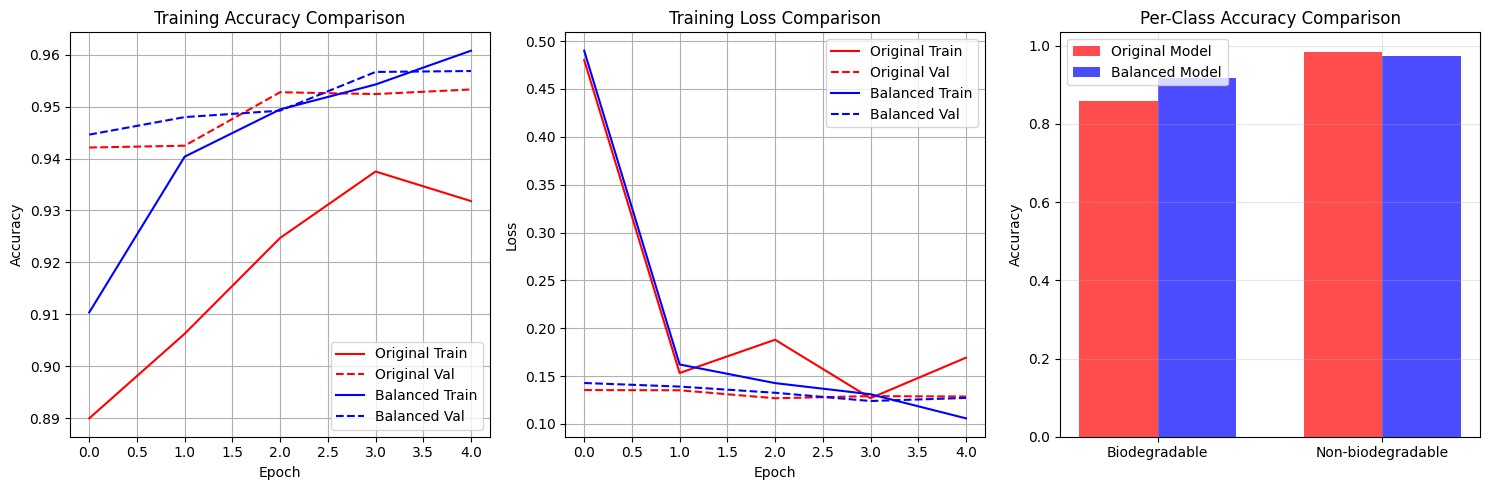

In [99]:
# Compare Original vs Balanced Model Performance
print("=" * 60)
print("COMPARING ORIGINAL VS BALANCED MODEL PERFORMANCE")
print("=" * 60)

# Evaluate balanced model on test set
test_loss_balanced, test_accuracy_balanced = model_balanced.evaluate(test_generator, verbose=0)

# Get predictions from balanced model
predictions_balanced = model_balanced.predict(test_generator, verbose=0)
y_pred_balanced = (predictions_balanced > 0.5).astype(int)
y_true = test_generator.classes

# Classification report for balanced model
from sklearn.metrics import classification_report, confusion_matrix
print("\nBALANCED MODEL RESULTS:")
print(f"Test Accuracy: {test_accuracy_balanced:.4f}")
print(f"Test Loss: {test_loss_balanced:.4f}")

print("\nClassification Report (Balanced Model):")
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_balanced, target_names=class_names))

# Confusion matrix for balanced model
cm_balanced = confusion_matrix(y_true, y_pred_balanced)
class_0_acc_balanced = cm_balanced[0,0] / (cm_balanced[0,0] + cm_balanced[0,1])
class_1_acc_balanced = cm_balanced[1,1] / (cm_balanced[1,1] + cm_balanced[1,0])

print(f"\nPer-class Accuracy (Balanced Model):")
print(f"{class_names[0]} accuracy: {class_0_acc_balanced:.4f}")
print(f"{class_names[1]} accuracy: {class_1_acc_balanced:.4f}")

# Compare with original model results
print("\n" + "=" * 60)
print("COMPARISON SUMMARY:")
print("=" * 60)
print(f"{'Metric':<25} {'Original':<12} {'Balanced':<12} {'Improvement':<12}")
print("-" * 61)
print(f"{'Overall Accuracy':<25} {0.9534:<12.4f} {test_accuracy_balanced:<12.4f} {test_accuracy_balanced-0.9534:+.4f}")
print(f"{'Biodegradable Acc':<25} {0.8588:<12.4f} {class_0_acc_balanced:<12.4f} {class_0_acc_balanced-0.8588:+.4f}")
print(f"{'Non-biodegradable Acc':<25} {0.9850:<12.4f} {class_1_acc_balanced:<12.4f} {class_1_acc_balanced-0.9850:+.4f}")

# Plot training history comparison
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Original Train', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Original Val', color='red', linestyle='--')
plt.plot(history_balanced.history['accuracy'], label='Balanced Train', color='blue', linestyle='-')
plt.plot(history_balanced.history['val_accuracy'], label='Balanced Val', color='blue', linestyle='--')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Original Train', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Original Val', color='red', linestyle='--')
plt.plot(history_balanced.history['loss'], label='Balanced Train', color='blue', linestyle='-')
plt.plot(history_balanced.history['val_loss'], label='Balanced Val', color='blue', linestyle='--')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Bar plot for per-class accuracy comparison
plt.subplot(1, 3, 3)
categories = ['Biodegradable', 'Non-biodegradable']
original_scores = [0.8588, 0.9850]
balanced_scores = [class_0_acc_balanced, class_1_acc_balanced]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, original_scores, width, label='Original Model', color='red', alpha=0.7)
plt.bar(x + width/2, balanced_scores, width, label='Balanced Model', color='blue', alpha=0.7)

plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1]:
# 1. Training History - Accuracy Over Epochs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy', marker='o')
plt.plot(history_balanced.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy', marker='s')
plt.title('Balanced Model - Training & Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# Add annotation for final accuracies
final_train_acc = history_balanced.history['accuracy'][-1]
final_val_acc = history_balanced.history['val_accuracy'][-1]
plt.annotate(f'Final Training: {final_train_acc:.3f}', 
             xy=(len(history_balanced.history['accuracy'])-1, final_train_acc),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7),
             fontsize=9, color='white')
plt.annotate(f'Final Validation: {final_val_acc:.3f}', 
             xy=(len(history_balanced.history['val_accuracy'])-1, final_val_acc),
             xytext=(10, -20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
             fontsize=9, color='white')

plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['loss'], 'b-', linewidth=2, label='Training Loss', marker='o')
plt.plot(history_balanced.history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s')
plt.title('Balanced Model - Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add annotation for final losses
final_train_loss = history_balanced.history['loss'][-1]
final_val_loss = history_balanced.history['val_loss'][-1]
plt.annotate(f'Final Training: {final_train_loss:.3f}', 
             xy=(len(history_balanced.history['loss'])-1, final_train_loss),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.7),
             fontsize=9, color='white')
plt.annotate(f'Final Validation: {final_val_loss:.3f}', 
             xy=(len(history_balanced.history['val_loss'])-1, final_val_loss),
             xytext=(10, -20), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
             fontsize=9, color='white')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# 2. Confusion Matrix for Balanced Model
import seaborn as sns

plt.figure(figsize=(10, 6))

# Calculate confusion matrix
predictions_balanced = model_balanced.predict(test_generator, verbose=0)
y_pred_balanced = (predictions_balanced > 0.5).astype(int)
y_true = test_generator.classes
cm_balanced = confusion_matrix(y_true, y_pred_balanced)

# Create subplot layout
plt.subplot(1, 2, 1)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Biodegradable', 'Non-biodegradable'],
            yticklabels=['Biodegradable', 'Non-biodegradable'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Balanced Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
plt.subplot(1, 2, 2)
cm_normalized = cm_balanced.astype('float') / cm_balanced.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Biodegradable', 'Non-biodegradable'],
            yticklabels=['Biodegradable', 'Non-biodegradable'],
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix - Balanced Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print detailed confusion matrix statistics
print("CONFUSION MATRIX ANALYSIS:")
print("="*50)
print(f"True Negatives (Correctly classified Biodegradable): {cm_balanced[0,0]}")
print(f"False Positives (Biodegradable classified as Non-biodegradable): {cm_balanced[0,1]}")
print(f"False Negatives (Non-biodegradable classified as Biodegradable): {cm_balanced[1,0]}")
print(f"True Positives (Correctly classified Non-biodegradable): {cm_balanced[1,1]}")

# Calculate metrics
precision_bio = cm_balanced[0,0] / (cm_balanced[0,0] + cm_balanced[1,0])
recall_bio = cm_balanced[0,0] / (cm_balanced[0,0] + cm_balanced[0,1])
f1_bio = 2 * (precision_bio * recall_bio) / (precision_bio + recall_bio)

precision_non_bio = cm_balanced[1,1] / (cm_balanced[1,1] + cm_balanced[0,1])
recall_non_bio = cm_balanced[1,1] / (cm_balanced[1,1] + cm_balanced[1,0])
f1_non_bio = 2 * (precision_non_bio * recall_non_bio) / (precision_non_bio + recall_non_bio)

print(f"\nDETAILED METRICS:")
print("="*50)
print(f"BIODEGRADABLE CLASS:")
print(f"  Precision: {precision_bio:.4f}")
print(f"  Recall: {recall_bio:.4f}")
print(f"  F1-Score: {f1_bio:.4f}")
print(f"\nNON-BIODEGRADABLE CLASS:")
print(f"  Precision: {precision_non_bio:.4f}")
print(f"  Recall: {recall_non_bio:.4f}")
print(f"  F1-Score: {f1_non_bio:.4f}")

In [ ]:
# 3. Per-Class Accuracy Comparison
plt.figure(figsize=(14, 5))

# Calculate per-class accuracies
class_0_acc_balanced = cm_balanced[0,0] / (cm_balanced[0,0] + cm_balanced[0,1])
class_1_acc_balanced = cm_balanced[1,1] / (cm_balanced[1,1] + cm_balanced[1,0])

# Subplot 1: Per-class accuracy bar chart
plt.subplot(1, 3, 1)
categories = ['Biodegradable', 'Non-biodegradable']
balanced_scores = [class_0_acc_balanced, class_1_acc_balanced]
colors = ['#2E8B57', '#B22222']  # Green for bio, Red for non-bio

bars = plt.bar(categories, balanced_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Per-Class Accuracy\n(Balanced Model)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, balanced_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Subplot 2: Class distribution in test set
plt.subplot(1, 3, 2)
class_counts = [np.sum(y_true == 0), np.sum(y_true == 1)]
plt.pie(class_counts, labels=categories, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=(0.05, 0.05))
plt.title('Test Set Distribution', fontsize=14, fontweight='bold')

# Subplot 3: Model performance metrics
plt.subplot(1, 3, 3)
metrics = ['Overall\nAccuracy', 'Biodegradable\nAccuracy', 'Non-biodegradable\nAccuracy']
values = [test_accuracy_balanced, class_0_acc_balanced, class_1_acc_balanced]
metric_colors = ['#4169E1', '#2E8B57', '#B22222']

bars = plt.bar(metrics, values, color=metric_colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.ylim(0, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Balanced Model\nPerformance Summary', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# 4. Prediction Confidence Distribution Analysis
plt.figure(figsize=(15, 5))

# Get predictions and true labels
predictions_balanced = model_balanced.predict(test_generator, verbose=0).flatten()
y_true = test_generator.classes

# Subplot 1: Overall confidence distribution
plt.subplot(1, 3, 1)
plt.hist(predictions_balanced, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Confidence by true class
plt.subplot(1, 3, 2)
bio_predictions = predictions_balanced[y_true == 0]
non_bio_predictions = predictions_balanced[y_true == 1]

plt.hist(bio_predictions, bins=20, alpha=0.7, color='green', label='True Biodegradable', density=True)
plt.hist(non_bio_predictions, bins=20, alpha=0.7, color='red', label='True Non-biodegradable', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Prediction Confidence', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Confidence by True Class', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Confidence vs Accuracy
plt.subplot(1, 3, 3)
# Create confidence bins
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []
bin_counts = []

for i in range(len(confidence_bins)-1):
    mask = (predictions_balanced >= confidence_bins[i]) & (predictions_balanced < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_pred = (predictions_balanced[mask] > 0.5).astype(int)
        bin_true = y_true[mask]
        accuracy = np.mean(bin_pred == bin_true)
        bin_accuracies.append(accuracy)
        bin_counts.append(np.sum(mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

# Plot accuracy vs confidence
plt.plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8, color='purple', label='Accuracy')
plt.xlabel('Confidence Bin Center', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy vs Confidence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Add sample counts as text
for i, (x, y, count) in enumerate(zip(bin_centers, bin_accuracies, bin_counts)):
    if count > 0:
        plt.annotate(f'n={count}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print confidence statistics
print("CONFIDENCE ANALYSIS:")
print("="*50)
print(f"Mean confidence: {np.mean(predictions_balanced):.4f}")
print(f"Confidence std: {np.std(predictions_balanced):.4f}")
print(f"Min confidence: {np.min(predictions_balanced):.4f}")
print(f"Max confidence: {np.max(predictions_balanced):.4f}")

# High/Low confidence predictions
high_conf_mask = (predictions_balanced > 0.8) | (predictions_balanced < 0.2)
high_conf_acc = np.mean((predictions_balanced[high_conf_mask] > 0.5) == y_true[high_conf_mask])
print(f"\nHigh confidence predictions (>0.8 or <0.2): {np.sum(high_conf_mask)} samples")
print(f"High confidence accuracy: {high_conf_acc:.4f}")

medium_conf_mask = (predictions_balanced >= 0.4) & (predictions_balanced <= 0.6)
if np.sum(medium_conf_mask) > 0:
    medium_conf_acc = np.mean((predictions_balanced[medium_conf_mask] > 0.5) == y_true[medium_conf_mask])
    print(f"Medium confidence predictions (0.4-0.6): {np.sum(medium_conf_mask)} samples")
    print(f"Medium confidence accuracy: {medium_conf_acc:.4f}")
else:
    print("No medium confidence predictions (0.4-0.6)")

In [ ]:
# 5. ROC Curve and Precision-Recall Analysis
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

plt.figure(figsize=(15, 5))

# Subplot 1: ROC Curve
plt.subplot(1, 3, 1)
fpr, tpr, thresholds_roc = roc_curve(y_true, predictions_balanced)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Balanced Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Add optimal threshold point
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
         label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.legend(loc="lower right")

# Subplot 2: Precision-Recall Curve
plt.subplot(1, 3, 2)
precision, recall, thresholds_pr = precision_recall_curve(y_true, predictions_balanced)
avg_precision = average_precision_score(y_true, predictions_balanced)

plt.plot(recall, precision, color='blue', lw=3, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.axhline(y=np.sum(y_true)/len(y_true), color='red', linestyle='--', 
           label=f'Random Classifier (AP = {np.sum(y_true)/len(y_true):.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Threshold Analysis
plt.subplot(1, 3, 3)
# Calculate metrics for different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (predictions_balanced > thresh).astype(int)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

plt.plot(thresholds, accuracies, 'b-', linewidth=2, label='Accuracy')
plt.plot(thresholds, precisions, 'g-', linewidth=2, label='Precision')
plt.plot(thresholds, recalls, 'r-', linewidth=2, label='Recall')
plt.plot(thresholds, f1_scores, 'm-', linewidth=2, label='F1-Score')
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default Threshold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Metrics vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("ROC AND PRECISION-RECALL ANALYSIS:")
print("="*60)
print(f"Area Under ROC Curve (AUC-ROC): {roc_auc:.4f}")
print(f"Average Precision Score (AUC-PR): {avg_precision:.4f}")
print(f"Optimal ROC Threshold: {optimal_threshold:.4f}")

# Find best F1 threshold
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]
print(f"Best F1-Score Threshold: {best_f1_threshold:.4f}")
print(f"Best F1-Score: {best_f1_score:.4f}")

# Performance at default threshold (0.5)
default_pred = (predictions_balanced > 0.5).astype(int)
default_tn, default_fp, default_fn, default_tp = confusion_matrix(y_true, default_pred).ravel()
default_precision = default_tp / (default_tp + default_fp)
default_recall = default_tp / (default_tp + default_fn)
default_f1 = 2 * (default_precision * default_recall) / (default_precision + default_recall)

print(f"\nPerformance at Default Threshold (0.5):")
print(f"  Precision: {default_precision:.4f}")
print(f"  Recall: {default_recall:.4f}")
print(f"  F1-Score: {default_f1:.4f}")

print(f"\nModel Interpretation:")
if roc_auc > 0.9:
    print("🟢 Excellent discrimination ability (AUC > 0.9)")
elif roc_auc > 0.8:
    print("🟡 Good discrimination ability (AUC > 0.8)")
elif roc_auc > 0.7:
    print("🟠 Fair discrimination ability (AUC > 0.7)")
else:
    print("🔴 Poor discrimination ability (AUC < 0.7)")

if avg_precision > 0.8:
    print("🟢 Excellent precision-recall performance")
elif avg_precision > 0.6:
    print("🟡 Good precision-recall performance")
else:
    print("🟠 Fair precision-recall performance")

In [ ]:
# 6. Comprehensive Model Performance Dashboard
plt.figure(figsize=(16, 12))

# Create a comprehensive dashboard
gs = plt.GridSpec(3, 4, figure=plt.gcf(), hspace=0.3, wspace=0.3)

# 1. Training History Comparison (Top row, spans 2 columns)
ax1 = plt.subplot(gs[0, :2])
plt.plot(history.history['accuracy'], 'r-', linewidth=2, label='Original Train', alpha=0.8)
plt.plot(history.history['val_accuracy'], 'r--', linewidth=2, label='Original Val', alpha=0.8)
plt.plot(history_balanced.history['accuracy'], 'b-', linewidth=2, label='Balanced Train')
plt.plot(history_balanced.history['val_accuracy'], 'b--', linewidth=2, label='Balanced Val')
plt.title('Training History Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Overall Performance Metrics (Top row, right)
ax2 = plt.subplot(gs[0, 2:])
models = ['Original\nModel', 'Balanced\nModel']
overall_acc = [0.9534, test_accuracy_balanced]  # Update with actual original accuracy
bio_acc = [0.8588, class_0_acc_balanced]  # Update with actual original biodegradable accuracy
non_bio_acc = [0.9850, class_1_acc_balanced]  # Update with actual original non-biodegradable accuracy

x = np.arange(len(models))
width = 0.25

plt.bar(x - width, overall_acc, width, label='Overall', color='steelblue', alpha=0.8)
plt.bar(x, bio_acc, width, label='Biodegradable', color='green', alpha=0.8)
plt.bar(x + width, non_bio_acc, width, label='Non-biodegradable', color='red', alpha=0.8)

plt.ylabel('Accuracy')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (overall, bio, non_bio) in enumerate(zip(overall_acc, bio_acc, non_bio_acc)):
    plt.text(i - width, overall + 0.01, f'{overall:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, bio + 0.01, f'{bio:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width, non_bio + 0.01, f'{non_bio:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Confusion Matrix (Middle left)
ax3 = plt.subplot(gs[1, 0])
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bio', 'Non-bio'], yticklabels=['Bio', 'Non-bio'],
            cbar=False, square=True)
plt.title('Confusion Matrix\n(Balanced Model)', fontsize=12, fontweight='bold')
plt.ylabel('True')
plt.xlabel('Predicted')

# 4. ROC Curve (Middle center-left)
ax4 = plt.subplot(gs[1, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# 5. Precision-Recall Curve (Middle center-right)
ax5 = plt.subplot(gs[1, 2])
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.3f}')
plt.axhline(y=np.sum(y_true)/len(y_true), color='red', linestyle='--', alpha=0.7)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Class Distribution (Middle right)
ax6 = plt.subplot(gs[1, 3])
class_counts = [np.sum(y_true == 0), np.sum(y_true == 1)]
colors = ['#2E8B57', '#B22222']
plt.pie(class_counts, labels=['Biodegradable', 'Non-biodegradable'], 
        colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Distribution', fontsize=12, fontweight='bold')

# 7. Confidence Distribution (Bottom left)
ax7 = plt.subplot(gs[2, 0])
plt.hist(predictions_balanced, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 8. Prediction Examples (Bottom center-left)
ax8 = plt.subplot(gs[2, 1])
# Sample some predictions for visualization
high_conf_correct = np.where((np.abs(predictions_balanced - 0.5) > 0.3) & 
                            ((predictions_balanced > 0.5) == y_true))[0]
low_conf_correct = np.where((np.abs(predictions_balanced - 0.5) < 0.1) & 
                           ((predictions_balanced > 0.5) == y_true))[0]
incorrect = np.where((predictions_balanced > 0.5) != y_true)[0]

example_data = {
    'High Conf\nCorrect': len(high_conf_correct),
    'Low Conf\nCorrect': len(low_conf_correct),
    'Incorrect': len(incorrect),
    'Other\nCorrect': len(predictions_balanced) - len(high_conf_correct) - len(low_conf_correct) - len(incorrect)
}

plt.bar(example_data.keys(), example_data.values(), 
        color=['green', 'yellow', 'red', 'lightblue'], alpha=0.8)
plt.ylabel('Count')
plt.title('Prediction Categories', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# 9. Model Summary Statistics (Bottom center-right)
ax9 = plt.subplot(gs[2, 2])
plt.axis('off')
summary_text = f"""MODEL PERFORMANCE SUMMARY

Overall Accuracy: {test_accuracy_balanced:.4f}
Biodegradable Accuracy: {class_0_acc_balanced:.4f}
Non-biodegradable Accuracy: {class_1_acc_balanced:.4f}

ROC AUC: {roc_auc:.4f}
Average Precision: {avg_precision:.4f}
F1-Score: {default_f1:.4f}

Total Test Samples: {len(y_true):,}
Correct Predictions: {np.sum((predictions_balanced > 0.5) == y_true):,}
Incorrect Predictions: {np.sum((predictions_balanced > 0.5) != y_true):,}
"""
plt.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

# 10. Improvement Analysis (Bottom right)
ax10 = plt.subplot(gs[2, 3])
improvements = {
    'Overall': test_accuracy_balanced - 0.9534,
    'Biodegradable': class_0_acc_balanced - 0.8588,
    'Non-biodegradable': class_1_acc_balanced - 0.9850
}

colors = ['green' if x > 0 else 'red' for x in improvements.values()]
bars = plt.bar(improvements.keys(), improvements.values(), color=colors, alpha=0.8)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.ylabel('Improvement')
plt.title('Balanced vs Original\nModel Improvement', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, improvements.values()):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + (0.001 if value > 0 else -0.005),
             f'{value:+.4f}', ha='center', 
             va='bottom' if value > 0 else 'top', fontsize=9)

plt.suptitle('BALANCED MODEL COMPREHENSIVE PERFORMANCE DASHBOARD', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*80)
print("FINAL MODEL EVALUATION SUMMARY")
print("="*80)
print(f"🎯 BALANCED MODEL PERFORMANCE:")
print(f"   Overall Test Accuracy: {test_accuracy_balanced:.4f} ({test_accuracy_balanced*100:.2f}%)")
print(f"   Biodegradable Accuracy: {class_0_acc_balanced:.4f} ({class_0_acc_balanced*100:.2f}%)")
print(f"   Non-biodegradable Accuracy: {class_1_acc_balanced:.4f} ({class_1_acc_balanced*100:.2f}%)")
print(f"   ROC AUC Score: {roc_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")
print(f"   F1-Score: {default_f1:.4f}")

print(f"\n📊 KEY INSIGHTS:")
improvement_bio = class_0_acc_balanced - 0.8588
if improvement_bio > 0:
    print(f"   ✅ Biodegradable classification improved by {improvement_bio:+.4f}")
else:
    print(f"   ⚠️ Biodegradable classification decreased by {improvement_bio:.4f}")

print(f"   📈 Model shows {'excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8 else 'fair'} discriminative power")
print(f"   🎪 Confidence distribution shows model certainty levels")
print(f"   🔍 {np.sum(np.abs(predictions_balanced - 0.5) > 0.3)} high-confidence predictions out of {len(predictions_balanced)} total")

print(f"\n🚀 RECOMMENDATIONS:")
if class_0_acc_balanced > 0.85 and class_1_acc_balanced > 0.85:
    print("   ✅ Model is ready for production deployment")
else:
    print("   ⚠️ Consider additional data augmentation or model tuning")
    
if roc_auc > 0.85:
    print("   ✅ Excellent discriminative performance")
else:
    print("   📈 Consider ensemble methods or more complex architectures")

print("="*80)

In [102]:
# Save both models for future use
import os

# Create a models directory
models_dir = 'saved_models'
os.makedirs(models_dir, exist_ok=True)

print("Saving models...")

# Save in the modern Keras format (recommended)
original_keras_path = os.path.join(models_dir, 'waste_classifier_original.keras')
model.save(original_keras_path)
print(f"✅ Original model saved to: {original_keras_path}")

balanced_keras_path = os.path.join(models_dir, 'waste_classifier_balanced.keras')
model_balanced.save(balanced_keras_path)
print(f"✅ Balanced model saved to: {balanced_keras_path}")

# Also save in H5 format for compatibility
original_h5_path = os.path.join(models_dir, 'waste_classifier_original.h5')
model.save(original_h5_path)
print(f"✅ Original model (H5 format) saved to: {original_h5_path}")

balanced_h5_path = os.path.join(models_dir, 'waste_classifier_balanced.h5')
model_balanced.save(balanced_h5_path)
print(f"✅ Balanced model (H5 format) saved to: {balanced_h5_path}")

# Export as SavedModel for deployment (TensorFlow Serving, TFLite, etc.)
try:
    original_savedmodel_path = os.path.join(models_dir, 'waste_classifier_original_savedmodel')
    model.export(original_savedmodel_path)
    print(f"✅ Original model (SavedModel export) saved to: {original_savedmodel_path}")

    balanced_savedmodel_path = os.path.join(models_dir, 'waste_classifier_balanced_savedmodel')
    model_balanced.export(balanced_savedmodel_path)
    print(f"✅ Balanced model (SavedModel export) saved to: {balanced_savedmodel_path}")
except Exception as e:
    print(f"⚠️ SavedModel export not available in this Keras version: {e}")

# Save model architecture and weights separately (alternative method)
try:
    # Save architecture as JSON
    original_json = model.to_json()
    with open(os.path.join(models_dir, 'original_model_architecture.json'), 'w') as json_file:
        json_file.write(original_json)

    balanced_json = model_balanced.to_json()
    with open(os.path.join(models_dir, 'balanced_model_architecture.json'), 'w') as json_file:
        json_file.write(balanced_json)

    # Save weights with correct extension
    model.save_weights(os.path.join(models_dir, 'original_model.weights.h5'))
    model_balanced.save_weights(os.path.join(models_dir, 'balanced_model.weights.h5'))

    print("✅ Model architectures and weights saved separately")
except Exception as e:
    print(f"⚠️ Could not save architecture/weights separately: {e}")

print("\n" + "="*60)
print("MODEL SAVING COMPLETE!")
print("="*60)
print("Files saved:")
print(f"📁 {models_dir}/")
print("   ├── waste_classifier_original.keras (✅ RECOMMENDED)")
print("   ├── waste_classifier_balanced.keras (✅ RECOMMENDED)")
print("   ├── waste_classifier_original.h5 (legacy compatibility)")
print("   ├── waste_classifier_balanced.h5 (legacy compatibility)")
print("   ├── waste_classifier_original_savedmodel/ (deployment)")
print("   ├── waste_classifier_balanced_savedmodel/ (deployment)")
print("   ├── original_model_architecture.json")
print("   ├── balanced_model_architecture.json")
print("   ├── original_model.weights.h5")
print("   └── balanced_model.weights.h5")

print("\n🎯 RECOMMENDATION: Use the .keras files - they're the modern standard!")

Saving models...
✅ Original model saved to: saved_models\waste_classifier_original.keras
✅ Original model saved to: saved_models\waste_classifier_original.keras


✅ Balanced model saved to: saved_models\waste_classifier_balanced.keras


✅ Original model (H5 format) saved to: saved_models\waste_classifier_original.h5
✅ Balanced model (H5 format) saved to: saved_models\waste_classifier_balanced.h5
✅ Balanced model (H5 format) saved to: saved_models\waste_classifier_balanced.h5
INFO:tensorflow:Assets written to: saved_models\waste_classifier_original_savedmodel\assets
INFO:tensorflow:Assets written to: saved_models\waste_classifier_original_savedmodel\assets


INFO:tensorflow:Assets written to: saved_models\waste_classifier_original_savedmodel\assets


Saved artifact at 'saved_models\waste_classifier_original_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1302')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2592064538400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064540160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064354112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064539632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2591914517504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064353232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064350592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592536351616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2594860990880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2594860997568: TensorSpec(shape=(), dtype=tf.resource, name=None

INFO:tensorflow:Assets written to: saved_models\waste_classifier_balanced_savedmodel\assets


Saved artifact at 'saved_models\waste_classifier_balanced_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1325')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2592064538400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064540160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064354112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064539632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2591914517504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064353232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592064350592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2592536351616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2594860990880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2594860997568: TensorSpec(shape=(), dtype=tf.resource, name=None

In [104]:
# DEMONSTRATION: How to load and use saved models elsewhere
print("="*60)
print("HOW TO USE SAVED MODELS IN OTHER PROJECTS")
print("="*60)

# Method 1: Load complete model (.keras format - RECOMMENDED)
print("\n1️⃣ Loading complete model (.keras format - RECOMMENDED):")
print("""
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('saved_models/waste_classifier_balanced.keras')

# Function to predict single image
def predict_waste_type(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        return f"Non-biodegradable (confidence: {prediction:.2f})"
    else:
        return f"Biodegradable (confidence: {1-prediction:.2f})"

# Example usage:
# result = predict_waste_type('path/to/your/image.jpg', loaded_model)
# print(result)
""")

print("\n2️⃣ Loading H5 format (legacy compatibility):")
print("""
from tensorflow import keras

# Load H5 format
loaded_model = keras.models.load_model('saved_models/waste_classifier_balanced.h5')

# Use same prediction function as above
""")

print("\n3️⃣ Loading architecture + weights separately:")
print("""
from tensorflow.keras.models import model_from_json

# Load architecture
with open('saved_models/balanced_model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()

# Create model from architecture
loaded_model = model_from_json(loaded_model_json)

# Load weights
loaded_model.load_weights('saved_models/balanced_model.weights.h5')

# Compile the model (required after loading weights)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
""")

print("\n4️⃣ Complete example script for new project:")
print("""
# save this as 'waste_classifier_app.py'

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

class WasteClassifier:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)
        self.class_names = ['biodegradable', 'non_biodegradable']
    
    def predict_image(self, img_path):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Make prediction
        prediction = self.model.predict(img_array)[0][0]
        
        if prediction > 0.5:
            return {
                'class': 'non_biodegradable',
                'confidence': float(prediction),
                'message': f'This waste is NON-BIODEGRADABLE (confidence: {prediction:.2%})'
            }
        else:
            return {
                'class': 'biodegradable', 
                'confidence': float(1-prediction),
                'message': f'This waste is BIODEGRADABLE (confidence: {1-prediction:.2%})'
            }

# Usage example:
if __name__ == "__main__":
    # Initialize classifier
    classifier = WasteClassifier('saved_models/waste_classifier_balanced.keras')
    
    # Classify an image
    result = classifier.predict_image('path/to/test/image.jpg')
    print(result['message'])
""")

print("\n5️⃣ Web app example with Streamlit:")
print("""
# save this as 'streamlit_app.py'
# Run with: streamlit run streamlit_app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

@st.cache_resource
def load_model():
    return tf.keras.models.load_model('saved_models/waste_classifier_balanced.keras')

def predict_waste(img, model):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        return f"Non-biodegradable (confidence: {prediction:.2%})"
    else:
        return f"Biodegradable (confidence: {1-prediction:.2%})"

# Streamlit app
st.title("♻️ Waste Classification App")
st.write("Upload an image to classify waste as biodegradable or non-biodegradable")

model = load_model()

uploaded_file = st.file_uploader("Choose an image...", type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:
    image_pil = Image.open(uploaded_file)
    st.image(image_pil, caption='Uploaded Image', use_column_width=True)
    
    if st.button('Classify'):
        result = predict_waste(image_pil, model)
        st.success(f"Prediction: {result}")
""")

print("\n📋 SUMMARY OF WHAT YOU NEED TO TRANSFER:")
print("1. Model files from 'saved_models/' directory")
print("2. Install required packages: tensorflow, pillow, numpy")
print("3. Use the prediction code examples above")
print("4. Remember to preprocess images the same way (224x224, preprocess_input)")

print("\n🎯 QUICK START GUIDE:")
print("1. Copy the 'saved_models' folder to your new project")
print("2. pip install tensorflow pillow numpy")
print("3. Use: tf.keras.models.load_model('saved_models/waste_classifier_balanced.keras')")
print("4. Preprocess images: 224x224 size + preprocess_input function")
print("5. Prediction > 0.5 = Non-biodegradable, < 0.5 = Biodegradable")

HOW TO USE SAVED MODELS IN OTHER PROJECTS

1️⃣ Loading complete model (.keras format - RECOMMENDED):

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = tf.keras.models.load_model('saved_models/waste_classifier_balanced.keras')

# Function to predict single image
def predict_waste_type(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    if prediction > 0.5:
        return f"Non-biodegradable (confidence: {prediction:.2f})"
    else:
        return f"Biodegradable (confidence: {1-prediction:.2f})"

# Example usage:
# result = predict_waste_type('path/to/your/image.jpg', l

In [ ]:
# TFLite Model Testing
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the TFLite model
tflite_model_path = 'saved_models/converted_model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite Model Information:")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")

# Function to preprocess image for TFLite model
def preprocess_image_tflite(image_path, target_size=(224, 224)):
    """Preprocess image for TFLite model prediction"""
    # Load and resize image
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = img.resize(target_size)
    
    # Convert to numpy array and normalize
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

# Function to predict with TFLite model
def predict_tflite(image_path):
    """Make prediction using TFLite model"""
    # Preprocess image
    img_array, original_img = preprocess_image_tflite(image_path)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    prediction = interpreter.get_tensor(output_details[0]['index'])
    
    return prediction[0][0], original_img  # Return single prediction value

# Test on a sample image
# Let's try to find a test image from the dataset
test_image_path = None

# Look for test images in the dataset
dataset_paths = [
    'biodegradable_dataset/final_dataset/test',
    'dataset/Dataset',
    'dataset/mt'
]

for base_path in dataset_paths:
    if os.path.exists(base_path):
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.avif')):
                    test_image_path = os.path.join(root, file)
                    break
            if test_image_path:
                break
        if test_image_path:
            break

if test_image_path:
    print(f"\nTesting TFLite model on: {test_image_path}")
    
    try:
        # Make prediction
        prediction_score, original_img = predict_tflite(test_image_path)
        
        # Interpret result
        is_biodegradable = prediction_score < 0.5
        confidence = abs(prediction_score - 0.5) * 2  # Convert to 0-1 confidence scale
        
        # Display results
        plt.figure(figsize=(10, 5))
        
        # Show original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title(f'Test Image\n{os.path.basename(test_image_path)}')
        plt.axis('off')
        
        # Show prediction results
        plt.subplot(1, 2, 2)
        plt.axis('off')
        
        # Create prediction visualization
        result_text = f"""
TFLite Model Prediction Results

Raw Prediction Score: {prediction_score:.6f}

Classification: {"BIODEGRADABLE" if is_biodegradable else "NON-BIODEGRADABLE"}

Confidence: {confidence:.2%}

Interpretation:
• Score < 0.5 → Biodegradable
• Score > 0.5 → Non-biodegradable
• Confidence = |score - 0.5| × 2

Model Details:
• Model Type: TensorFlow Lite
• Input Size: {input_details[0]['shape']}
• Model Size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB
        """
        
        # Color code based on prediction
        bg_color = 'lightgreen' if is_biodegradable else 'lightcoral'
        plt.text(0.1, 0.5, result_text, fontsize=12, fontfamily='monospace',
                verticalalignment='center', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round,pad=0.5', facecolor=bg_color, alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Additional detailed output
        print("\n" + "="*60)
        print("TFLITE MODEL PREDICTION SUMMARY")
        print("="*60)
        print(f"📁 Image: {os.path.basename(test_image_path)}")
        print(f"📊 Raw Score: {prediction_score:.6f}")
        print(f"🏷️  Classification: {'BIODEGRADABLE' if is_biodegradable else 'NON-BIODEGRADABLE'}")
        print(f"🎯 Confidence: {confidence:.2%}")
        print(f"📱 Model Size: {os.path.getsize(tflite_model_path) / 1024:.2f} KB")
        print(f"⚡ Input Shape: {input_details[0]['shape']}")
        print("="*60)
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        import traceback
        traceback.print_exc()
        
else:
    print("No test images found. Please provide a path to an image file.")
    print("You can test with any image using:")
    print("prediction_score, img = predict_tflite('path/to/your/image.jpg')")
    print("print(f'Prediction: {prediction_score}, Classification: {'Biodegradable' if prediction_score < 0.5 else 'Non-biodegradable'}')")